# 02450 Project


In [4]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


Load data of usa_wood_data_formatted.csv

In [5]:
data = pd.read_csv('C:/Users/ongji/OneDrive/Documents/DTU/02450 Introduction to Machine Learning and Data Mining/02450-Project-1/usa_wood_data_formatted.csv')
# print(data.head())  

Clean data by removing rows with missing values

In [6]:
data_cleaned = data.dropna()
print(data_cleaned.isnull().sum()) # 0 means data is clean

common_species_name                   0
genus                                 0
species                               0
scientific_name                       0
classification                        0
moisture_content                      0
specific_gravity                      0
modulus_of_rupture                    0
modulus_of_elasticity                 0
work_to_maximum_load                  0
impact_bending                        0
compression_parallel_to_grain         0
compression_perpendicular_to_grain    0
shear_parallel_to_grain               0
tension_perpendicular_to_grain        0
side_hardness                         0
dtype: int64


<span style="color:lightblue">**Visualize the relationship between 2 selected attributes of the usa_wood dataset, color-coded by class labels.**<span>

Class label used: classification
Attributes used: specific_gravity (6) and modulus_of_rupture (7)

All attributes and their corresponding numbers are printed.




In [7]:
# Extract attribute names (1st row, column 0 to 16)
attributeNames = data_cleaned.columns[:16]
for i in range(len(attributeNames)):
    print(i, attributeNames[i])

# Extract class names to python list,
# then encode with integers (dict)
classLabels = data_cleaned['classification'].values
classNames = sorted(set(classLabels))
classDict = {className: index for index, className in enumerate(classNames)}
y = np.array([classDict[label] for label in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = data_cleaned.iloc[:,0:16].values

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classNames)


# Data attributes to be plotted
i = 6
j = 7


# Plotting the wood data
# plt.figure(figsize=(12,8))
# for c in range(C):
#     class_mask = y == c
#     plt.scatter(X[class_mask, i], X[class_mask, j], label=classNames[c], alpha=0.5)
# plt.xlabel(attributeNames[i])
# plt.ylabel(attributeNames[j])
# plt.title("Wood Data with Class Labels")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
# plt.show()



0 common_species_name
1 genus
2 species
3 scientific_name
4 classification
5 moisture_content
6 specific_gravity
7 modulus_of_rupture
8 modulus_of_elasticity
9 work_to_maximum_load
10 impact_bending
11 compression_parallel_to_grain
12 compression_perpendicular_to_grain
13 shear_parallel_to_grain
14 tension_perpendicular_to_grain
15 side_hardness


# PCA

<span style="color:lightblue">**Perform PCA on the cleaned and scaled data X**<span>

From the plot, more than 90% of the data is in the first 3 components.


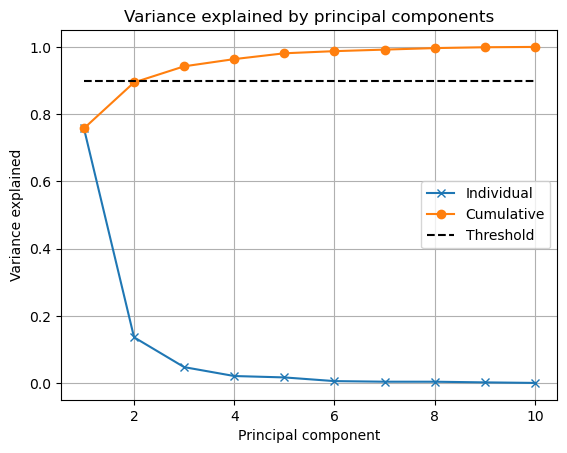


Attributes and their variance explained for PC1:
specific_gravity: 0.3368
modulus_of_rupture: 0.3298
modulus_of_elasticity: 0.2757
work_to_maximum_load: 0.3134
impact_bending: 0.2889
compression_parallel_to_grain: 0.2811
compression_perpendicular_to_grain: 0.3332
shear_parallel_to_grain: 0.3454
tension_perpendicular_to_grain: 0.3038
side_hardness: 0.3442

Attributes and their variance explained for PC2:
specific_gravity: -0.2079
modulus_of_rupture: 0.3394
modulus_of_elasticity: 0.3672
work_to_maximum_load: -0.2641
impact_bending: -0.4355
compression_parallel_to_grain: 0.5207
compression_perpendicular_to_grain: 0.1557
shear_parallel_to_grain: 0.0908
tension_perpendicular_to_grain: -0.3312
side_hardness: -0.1846

Attributes and their variance explained for PC3:
specific_gravity: -0.0158
modulus_of_rupture: 0.0566
modulus_of_elasticity: 0.6025
work_to_maximum_load: 0.3823
impact_bending: 0.3641
compression_parallel_to_grain: -0.0674
compression_perpendicular_to_grain: -0.3705
shear_paral

In [8]:
# Filter out numerical values
X_num = data_cleaned.iloc[:,6:16].values # change this once green is removed

# Scale and substract mean from data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
Y = X_scaled - np.ones((N, 1)) * X_scaled.mean(axis=0)

# PCA by computing SVD of Y
U, S, Vh = svd(Y, full_matrices=False)

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

# print("Singular values:", S)
# print("Variance explained:", rho)
# print("Cumulative variance explained:", np.cumsum(rho))

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()

# Print attributes and their corresponding variance explained values for the first three principal components
attributeNames_num = data_cleaned.columns[6:16]  # Numerical attributes only
pcs = [0, 1, 2]
for i in pcs:
    print(f"\nAttributes and their variance explained for PC{i + 1}:")
    for attr, var in zip(attributeNames_num, Vh[i, :]):
        print(f"{attr}: {var:.4f}")

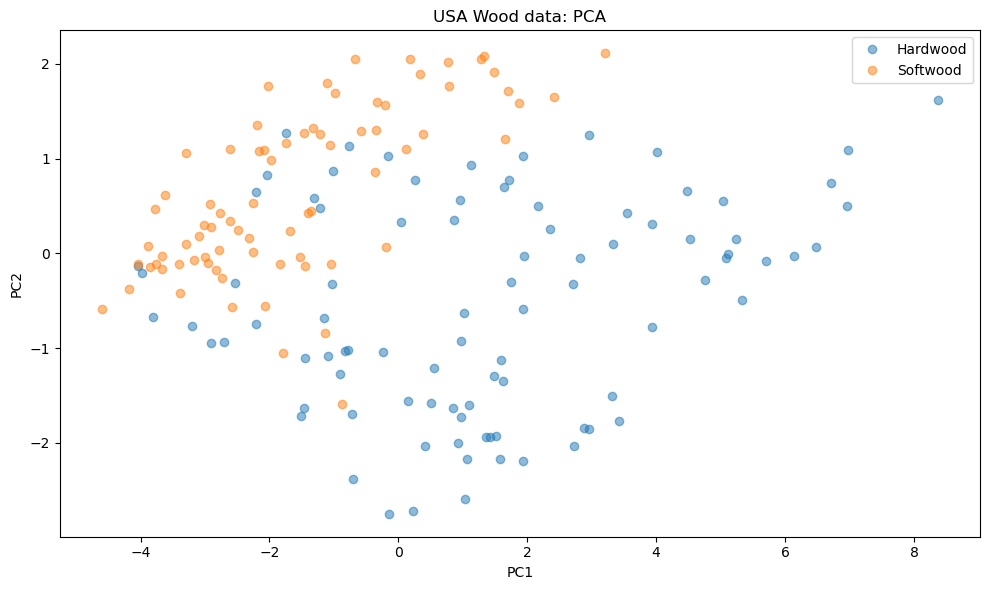

In [9]:
# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T

# Project the centered data onto principal component space
Z = Y @ V

# Indices of the principal components to be plotted
i = 0 # 1st PC
j = 1 # 2nd PC

# Plot PCA of the data
f = plt.figure(figsize=(10,6))
plt.title("USA Wood data: PCA")
# Z = array(Z)
for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    plt.plot(Z[class_mask, i], Z[class_mask, j], "o", alpha=0.5)

#plt.legend(classNames,loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(classNames)
plt.xlabel("PC{0}".format(i + 1))
plt.ylabel("PC{0}".format(j + 1))
plt.tight_layout()

# Output result to screen
plt.show()



3D plot of PCA using first 3 components

In [10]:
import plotly.express as px

df_pca = pd.DataFrame(Z[:, :3], columns=['PC1', 'PC2', 'PC3'])
df_pca['Genus'] = [classNames[label] for label in y]

# 3D scatter plot
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Genus', labels={'color': 'Genus'},
                    title="USA Wood Data: 3D PCA Visualization")
fig.update_traces(marker=dict(size=5, opacity=0.6)) 

fig.show()



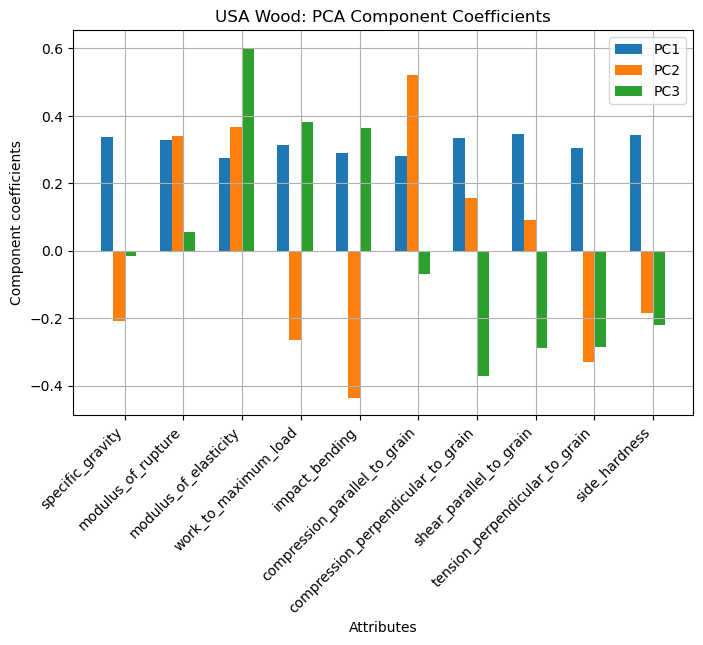

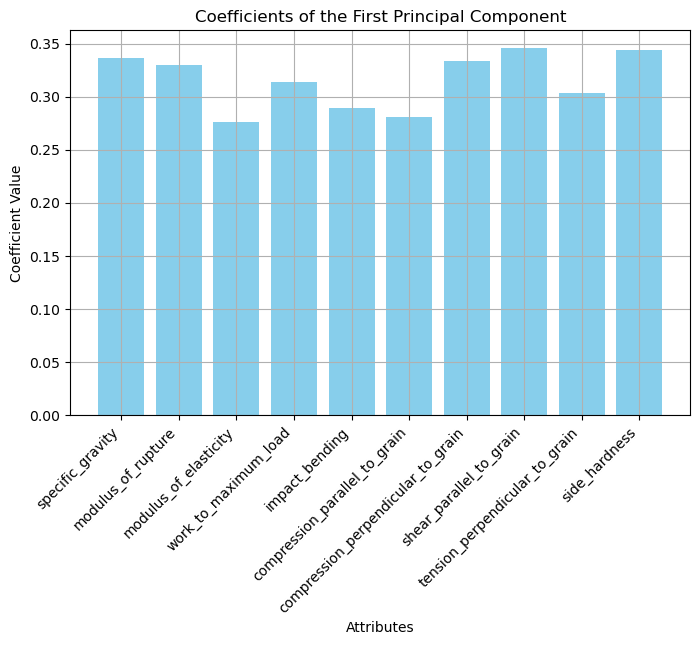


Attributes and their coefficients for PC1:
specific_gravity: 0.3368
modulus_of_rupture: 0.3298
modulus_of_elasticity: 0.2757
work_to_maximum_load: 0.3134
impact_bending: 0.2889
compression_parallel_to_grain: 0.2811
compression_perpendicular_to_grain: 0.3332
shear_parallel_to_grain: 0.3454
tension_perpendicular_to_grain: 0.3038
side_hardness: 0.3442

Attributes and their coefficients for PC2:
specific_gravity: -0.2079
modulus_of_rupture: 0.3394
modulus_of_elasticity: 0.3672
work_to_maximum_load: -0.2641
impact_bending: -0.4355
compression_parallel_to_grain: 0.5207
compression_perpendicular_to_grain: 0.1557
shear_parallel_to_grain: 0.0908
tension_perpendicular_to_grain: -0.3312
side_hardness: -0.1846

Attributes and their coefficients for PC3:
specific_gravity: -0.0158
modulus_of_rupture: 0.0566
modulus_of_elasticity: 0.6025
work_to_maximum_load: 0.3823
impact_bending: 0.3641
compression_parallel_to_grain: -0.0674
compression_perpendicular_to_grain: -0.3705
shear_parallel_to_grain: -0.2

In [11]:
N, M = X_scaled.shape # Number of samples and attributes 
attributeNames_num = data_cleaned.columns[6:16] # Numerical attributes only

# Plot coefficients of the first 3 PCs
pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
c = ["r", "g", "b"]
bw = 0.2
r = np.arange(1, M + 1)

plt.figure(figsize=(8,5)) 

for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw)

plt.xticks(r + bw * len(pcs) / 2, attributeNames_num, rotation=45, ha="right")
#plt.xticks(r + bw, attributeNames_num)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("USA Wood: PCA Component Coefficients")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(attributeNames_num, V[:, 0], color='skyblue')
plt.xlabel('Attributes')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the First Principal Component')
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.show()

# Print attributes and their coefficients for the first three principal components
pcs = [0, 1, 2]
for i in pcs:
    print(f"\nAttributes and their coefficients for PC{i + 1}:")
    for attr, coeff in zip(attributeNames_num, V[:, i]):
        print(f"{attr}: {coeff:.4f}")



We can see that the most influential attributes for Each Principal Component are as follows:

PC1 (Most Variation Explained):
1. Shear Parallel to Grain: 0.3454
2. Side Hardness: 0.3442
3. Compression Perpendicular to Grain: 0.3332
4. Specific Gravity: 0.3368
5. Modulus of Rupture: 0.3298

<span style="color:lightblue">Factors related to the structural integrity and wood density are very influential in explaining the variation in the dataset.</span>
<span>

PC2:
1. Compression Parallel to Grain: 0.5207
2. Impact Bending: -0.4355
3. Modulus of Elasticity: 0.3672
4. Modulus of Rupture: 0.3394

<span style="color:lightblue">Factors related to the how the wood withstands stress and strain, especially when pressure is applied along or across the grain, are very influential in explaining the variation in the dataset.</span>


PC3:
1. Modulus of Elasticity: 0.6025
2. Work to Maximum Load: 0.3823
3. Impact Bending: 0.3641

<span style="color:lightblue">Factors related to the  flexibility and the energy absorption capacity of the wood, are very influential in explaining the variation in the dataset.</span>



0 common_species_name
1 genus
2 species
3 scientific_name
4 classification
5 moisture_content
6 specific_gravity
7 modulus_of_rupture
8 modulus_of_elasticity
9 work_to_maximum_load
10 impact_bending
11 compression_parallel_to_grain
12 compression_perpendicular_to_grain
13 shear_parallel_to_grain
14 tension_perpendicular_to_grain
15 side_hardness


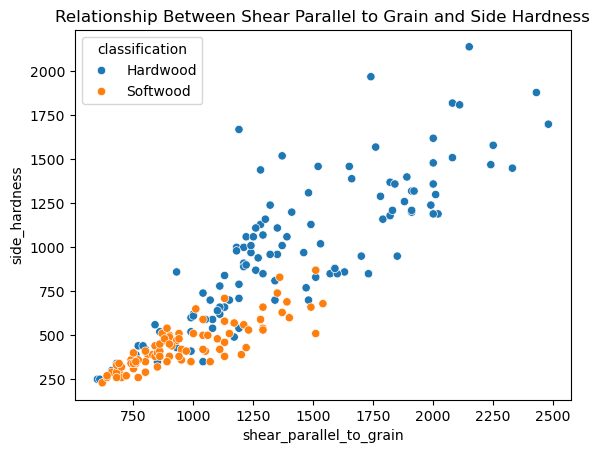

In [12]:
for i in range(len(attributeNames)):
    print(i, attributeNames[i])

i = 13
j = 15

# Plot the first two PC1 attributes against each other
import seaborn as sns
sns.scatterplot(data=data, x=attributeNames[i], y=attributeNames[j],hue='classification')
plt.title('Relationship Between Shear Parallel to Grain and Side Hardness')
plt.show()


# Plot the first two PC1 attributes against each other
# plt.figure(figsize=(6,5))
# for c in range(C):
#     class_mask = y == c
#     plt.scatter(X[class_mask, i], X[class_mask, j], label=classNames[c], alpha=0.5)
# plt.xlabel(attributeNames[i])
# plt.ylabel(attributeNames[j])
# plt.title("Wood Data with Class Labels")
# plt.legend()
# #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
# plt.show()


# Effect of standardization

<span style="color: lightblue">**More Detaiied analysis using PCA (Taken from ex2_1_6.py)**</span>

Find out how different data standardization methods (data using zero mean & data using both zero mean and unit variance) affect PCA results by visualizing the projections onto PCs, the coefficients of attributes in the PC space, and the variance explained by PCs. 


[1.01623100e-01 3.18897274e+03 3.04792937e-01 3.81354262e+00
 1.09336070e+01 1.79978525e+03 3.01916571e+02 3.94481438e+02
 2.19688431e+02 3.55038782e+02]


Text(0.5, 1.0, 'USA Wood: attribute standard deviations')

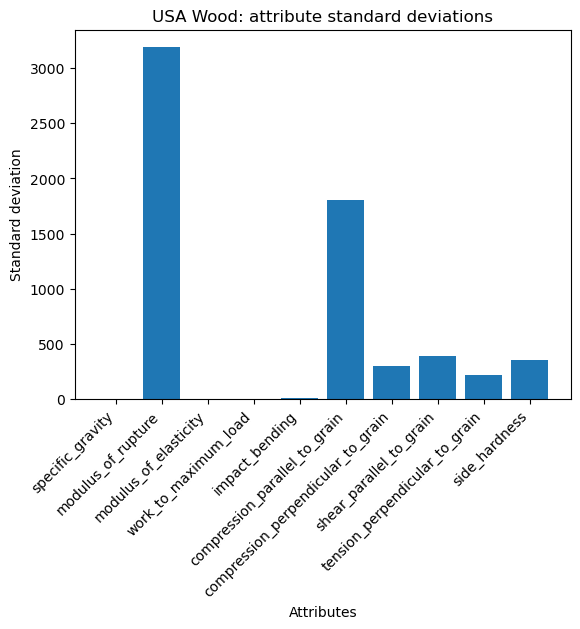

In [13]:
r = np.arange(1, X_num.shape[1] + 1)
plt.bar(r, np.std(X_num, 0))
plt.xticks(r, attributeNames_num, rotation=45, ha="right")
print(np.std(X_num, 0))
plt.ylabel("Standard deviation")
plt.xlabel("Attributes")
plt.title("USA Wood: attribute standard deviations")


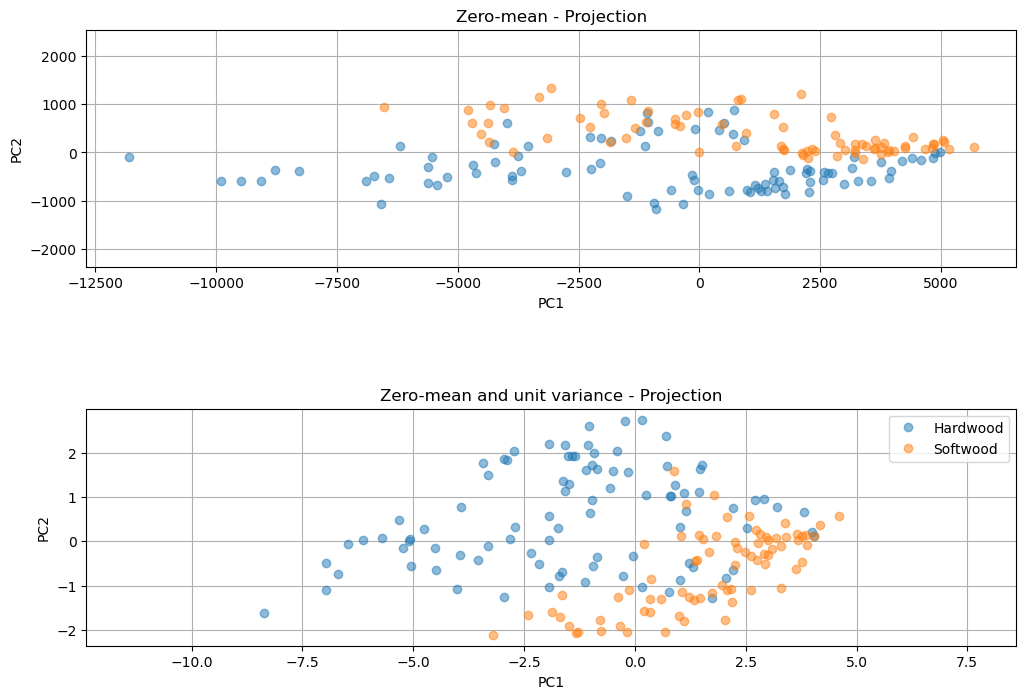

In [14]:
# Subtract the mean from the data
Y1 = X_num - np.ones((N, 1)) * X_num.mean(0)

# Subtract the mean from the data and divide by the attribute standard
# deviation to obtain a standardized dataset:
Y2 = X_num - np.ones((N, 1)) * X_num.mean(0)
Y2 = Y2 * (1 / np.std(Y2, 0)) 

# Store the two in a cell, so we can just loop over them:
Ys = [Y1, Y2]
titles = ["Zero-mean", "Zero-mean and unit variance"]
threshold = 0.9

# Choose two PCs to plot (the projection)
i = 0
j = 1

plt.figure(figsize=(12,8)) 
plt.subplots_adjust(hspace=0.6) 

# Loop over the standardized datasets
for k in range(2):
    # Obtain the PCA solution by calculate the SVD of either Y1 or Y2
    U, S, Vh = svd(Ys[k], full_matrices=False)
    V = Vh.T  # For the direction of V to fit the convention in the course we transpose
    # For visualization purposes, we flip the directionality of the
    # principal directions such that the directions match for Y1 and Y2.
    if k == 1:
        V = -V
        U = -U

    # Compute the projection onto the principal components
    Z = U * S

    
    # Plot projection
    ax1 = plt.subplot(2,1, k + 1)
    for c in range(len(classNames)):
        class_mask = y == c
        plt.plot(Z[class_mask, i], Z[class_mask, j], 'o', alpha=0.5, label=classNames[c])
    ax1.set_title(f"{titles[k]} - Projection")
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    #ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.grid(True)
    ax1.axis('equal')

plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

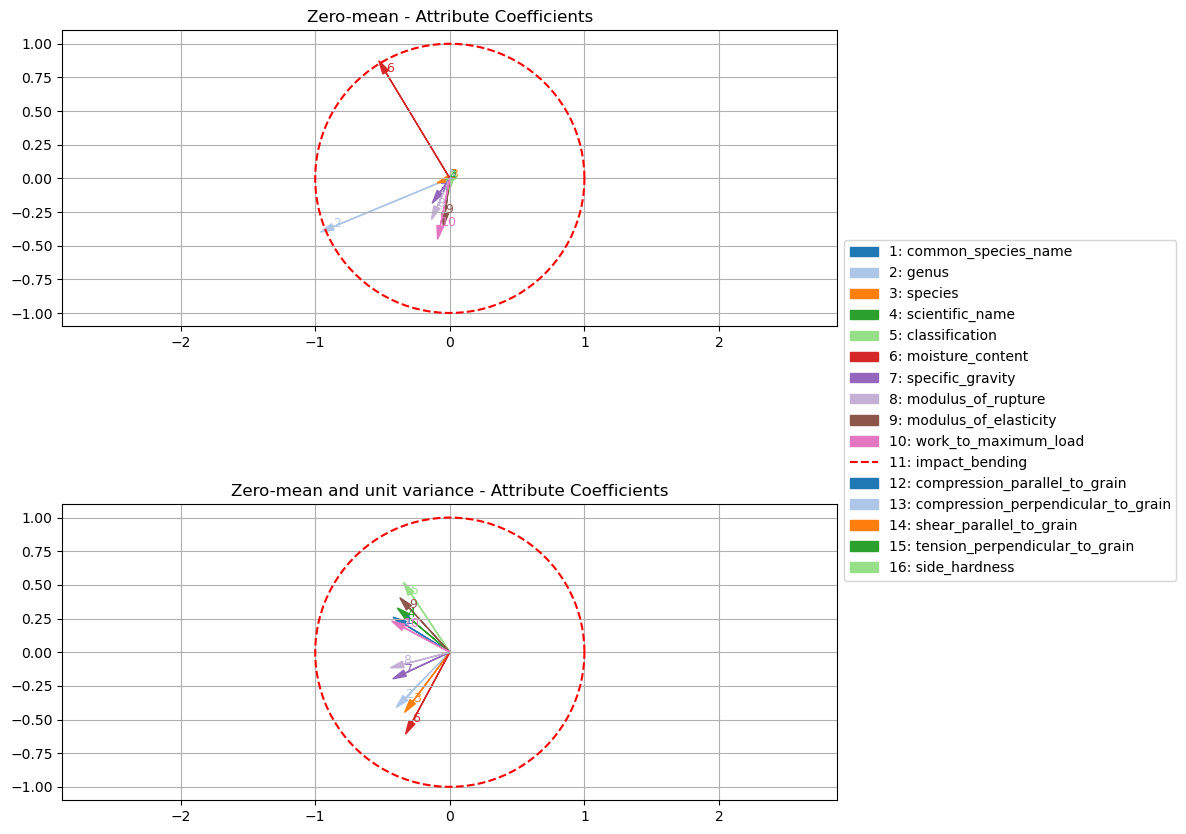

In [15]:
import matplotlib.cm as cm

plt.figure(figsize=(10,10)) 
plt.subplots_adjust(hspace=0.6) 

# Generate a list of colors
colors = cm.tab20(np.linspace(0, 1, len(attributeNames)))

# Loop over the standardized datasets
for k in range(2):
    # Obtain the PCA solution by calculate the SVD of either Y1 or Y2
    U, S, Vh = svd(Ys[k], full_matrices=False)
    V = Vh.T  # For the direction of V to fit the convention in the course we transpose
    # For visualization purposes, we flip the directionality of the
    # principal directions such that the directions match for Y1 and Y2.
    if k == 1:
        V = -V
        U = -U

    # Compute the projection onto the principal components
    Z = U * S

    # Plot attribute coefficients in principal component space
    ax2 = plt.subplot(2,1, k +1) 
    for att in range(V.shape[1]):
        ax2.arrow(0, 0, V[att, 0], V[att, 1], head_width=0.05, head_length=0.1, fc=colors[att % 20], ec=colors[att % 20])
        ax2.text(V[att, 0], V[att, 1], str(att + 1), fontsize=9, color=colors[att % 20])  # Number the attributes
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_title(f"{titles[k]} - Attribute Coefficients")
    ax2.grid(True)
    ax2.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), 'r--')  # Unit circle
    ax2.axis('equal')

# Create a legend for the attribute numbers
attribute_legend = [f"{i + 1}: {name}" for i, name in enumerate(attributeNames)]
#plt.legend(attribute_legend)
plt.figlegend(attribute_legend, loc='center left', bbox_to_anchor=(0.9, 0.5))

plt.show()

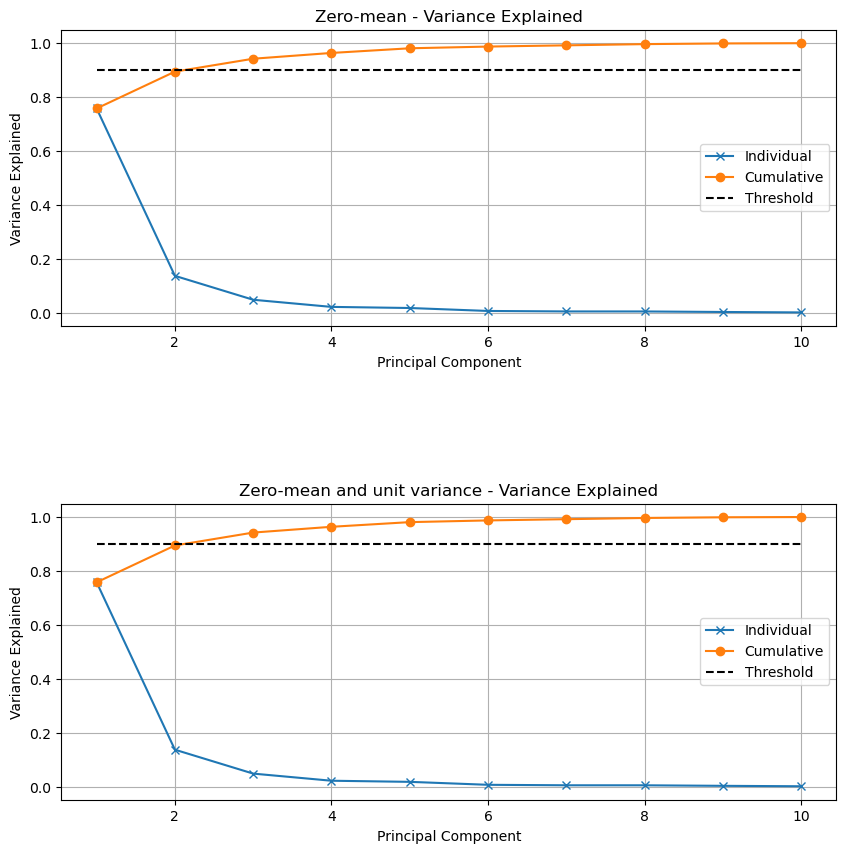

In [16]:
plt.figure(figsize=(10,10)) 
plt.subplots_adjust(hspace=0.6) 

# Loop over the standardized datasets
for k in range(2):
    # Obtain the PCA solution by calculate the SVD of either Y1 or Y2
    U, S, Vh = svd(Ys[k], full_matrices=False)
    V = Vh.T  # For the direction of V to fit the convention in the course we transpose
    # For visualization purposes, we flip the directionality of the
    # principal directions such that the directions match for Y1 and Y2.
    if k == 1:
        V = -V
        U = -U

    # Compute the projection onto the principal components
    Z = U * S

    # Plot cumulative variance explained
    ax3 = plt.subplot(2,1,k+1) 
    ax3.plot(range(1, len(rho) + 1), rho, 'x-')
    ax3.plot(range(1, len(rho) + 1), np.cumsum(rho), 'o-')
    ax3.plot([1, len(rho)], [threshold, threshold], 'k--')
    ax3.set_title(f"{titles[k]} - Variance Explained")
    ax3.set_xlabel('Principal Component')
    ax3.set_ylabel('Variance Explained')
    ax3.legend(['Individual', 'Cumulative', 'Threshold'])
    ax3.grid(True)

plt.show()

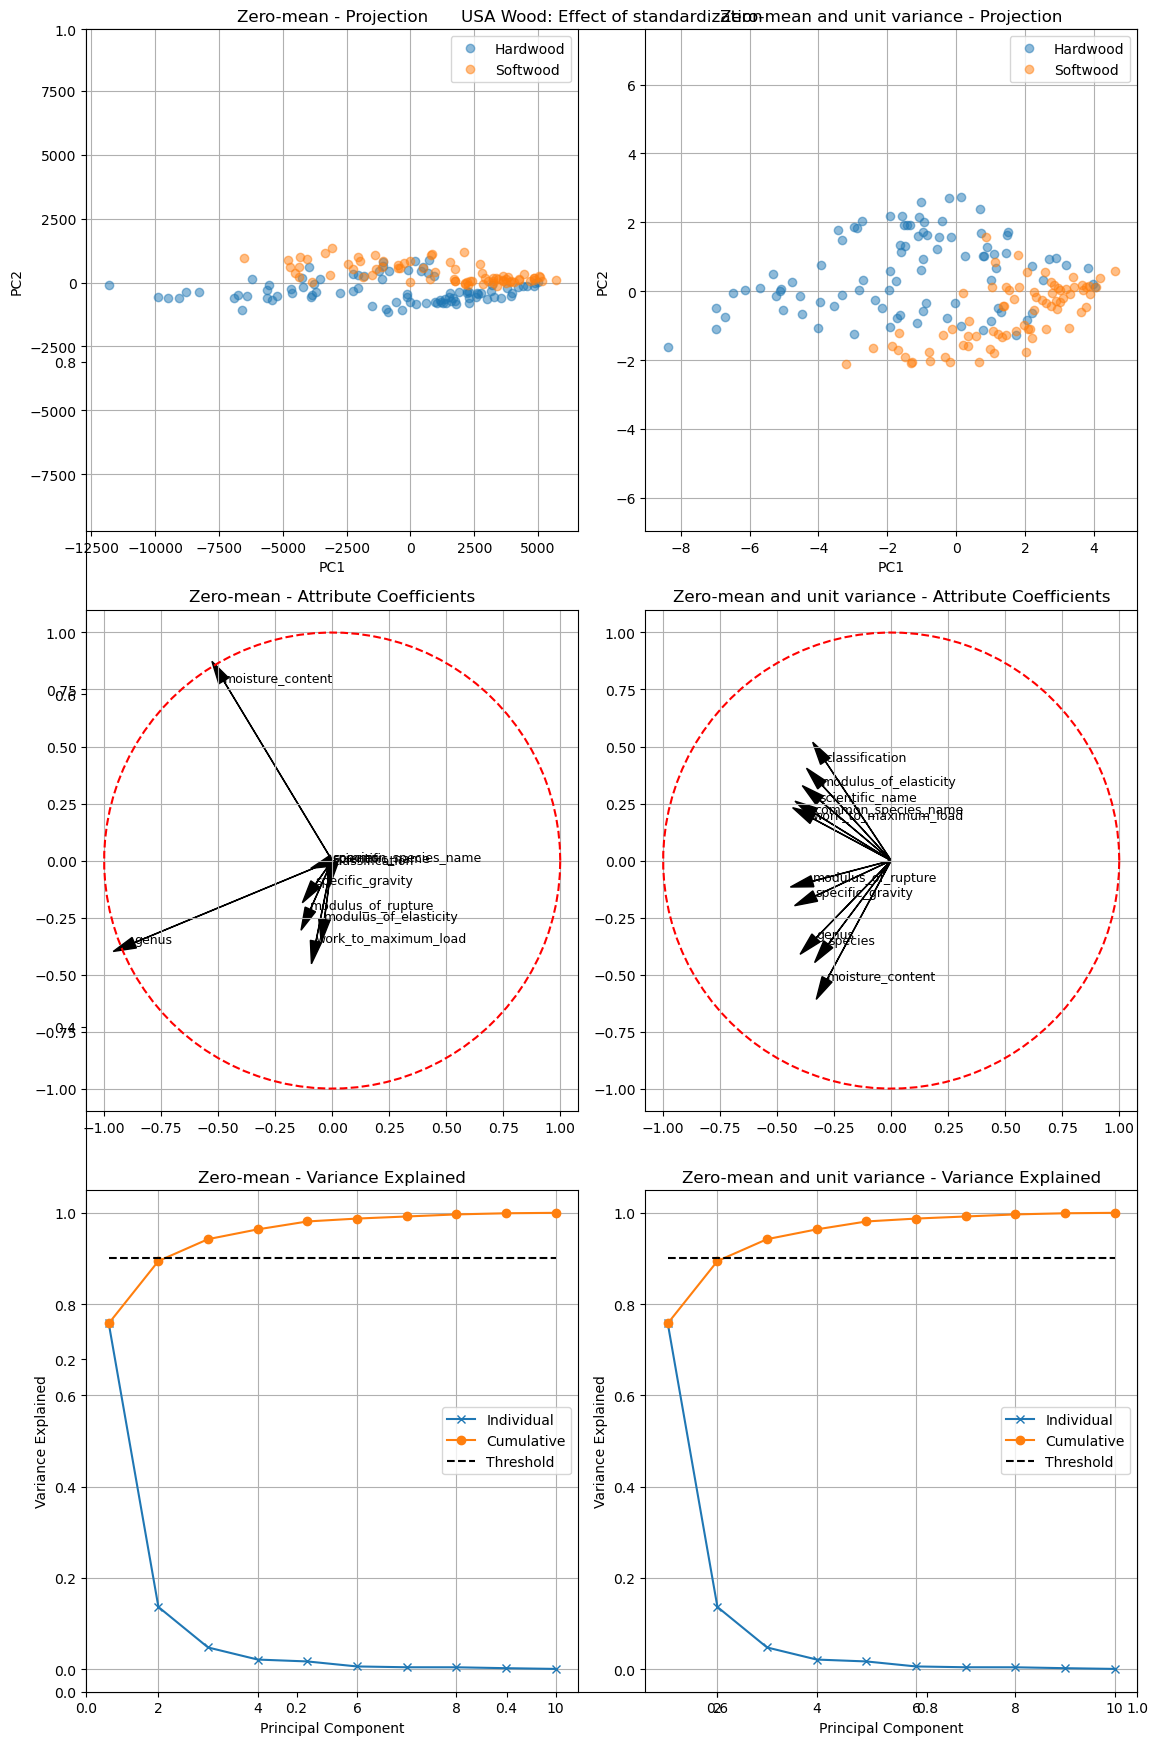

In [17]:
# All plots 

# Subtract the mean from the data
Y1 = X_num - np.ones((N, 1)) * X_num.mean(0)

# Subtract the mean from the data and divide by the attribute standard
# deviation to obtain a standardized dataset:
Y2 = X_num - np.ones((N, 1)) * X_num.mean(0)
Y2 = Y2 * (1 / np.std(Y2, 0)) 

# Store the two in a cell, so we can just loop over them:
Ys = [Y1, Y2]
titles = ["Zero-mean", "Zero-mean and unit variance"]
threshold = 0.9

# Choose two PCs to plot (the projection)
i = 0
j = 1

# Make the plot
plt.figure(figsize=(12, 18)) 
plt.subplots_adjust(hspace=0.6)  
plt.title("USA Wood: Effect of standardization")
nrows = 3
ncols = 2
for k in range(2):
    # Obtain the PCA solution by calculate the SVD of either Y1 or Y2
    U, S, Vh = svd(Ys[k], full_matrices=False)
    V = Vh.T  # For the direction of V to fit the convention in the course we transpose
    # For visualization purposes, we flip the directionality of the
    # principal directions such that the directions match for Y1 and Y2.
    if k == 1:
        V = -V
        U = -U

    # Compute the projection onto the principal components
    Z = U * S

    # Plot projection
    ax1 = plt.subplot(nrows, ncols, k + 1)  # First row, loop over columns
    for c in range(len(classNames)):
        class_mask = y == c
        ax1.plot(Z[class_mask, i], Z[class_mask, j], 'o', alpha=0.5, label=classNames[c])
    ax1.set_title(f"{titles[k]} - Projection")
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.legend()
    ax1.grid(True)
    ax1.axis('equal')

    # Plot attribute coefficients in principal component space
    ax2 = plt.subplot(nrows, ncols, k + 3)  # Second row, loop over columns
    for att in range(V.shape[1]):
        ax2.arrow(0, 0, V[att, i], V[att, j], head_width=0.05, head_length=0.1, fc='k', ec='k')
        ax2.text(V[att, i], V[att, j], attributeNames[att], fontsize=9)
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_title(f"{titles[k]} - Attribute Coefficients")
    ax2.grid(True)
    ax2.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), 'r--')  # Unit circle
    ax2.axis('equal')

    # Plot cumulative variance explained
    ax3 = plt.subplot(nrows, ncols, k + 5)  # Third row, loop over columns
    ax3.plot(range(1, len(rho) + 1), rho, 'x-')
    ax3.plot(range(1, len(rho) + 1), np.cumsum(rho), 'o-')
    ax3.plot([1, len(rho)], [threshold, threshold], 'k--')
    ax3.set_title(f"{titles[k]} - Variance Explained")
    ax3.set_xlabel('Principal Component')
    ax3.set_ylabel('Variance Explained')
    ax3.legend(['Individual', 'Cumulative', 'Threshold'])
    ax3.grid(True)


plt.tight_layout()  # This adjusts subplots to fit into figure area.
plt.show()
